In [109]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests

df0 = pd.read_csv("https://raw.githubusercontent.com/happy522/ChatGPT-as-a-CAT-tool-in-Easy-language-translation_Implemenatation/refs/heads/main/GPT_5_1/Matrix_Scores_GPT5_1_Administrative.csv").sort_values("ID")
df1 = pd.read_csv("https://raw.githubusercontent.com/happy522/ChatGPT-as-a-CAT-tool-in-Easy-language-translation_Implemenatation/refs/heads/main/llama-3.3-70b-instruct/Matrix_Scores_llama-3.3-70b-instruct_Administrative.csv").sort_values("ID")
df2 = pd.read_csv("https://raw.githubusercontent.com/happy522/ChatGPT-as-a-CAT-tool-in-Easy-language-translation_Implemenatation/refs/heads/main/qwen3-235b-a22b/Matrix_Scores_qwen3-235b-a22b_Administrative.csv").sort_values("ID")

lower_better = ["TTR", "LD", "WR", "MDD", "SI", "Cross", "WSF", "LIX", "Fog"]
higher_better = ["FRE"]

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_model_comparison(df, metric_type="Holistic"):

    # Long format for seaborn
    df_long = df.melt(
        id_vars=["Metric", "Significant_(p<0.05)"],
        value_vars=["GPT5.1_mean", "LLaMA_mean", "Qwen_mean"],
        var_name="Model",
        value_name="Score"
    )
    df_long["Model"] = df_long["Model"].str.replace("_mean", "")

    # --- Grouped bar chart ---
    plt.figure(figsize=(max(12, len(df)*0.8), 6))  # width scales with number of metrics
    ax = sns.barplot(data=df_long, x="Metric", y="Score", hue="Model", palette="Set2")

    # Add significance stars
    for i, row in df.iterrows():
        if row["Significant_(p<0.05)"]:
            max_score = max(row["GPT5.1_mean"], row["LLaMA_mean"], row["Qwen_mean"])
            plt.text(i, max_score + max_score*0.05, "*", ha='center', va='bottom', color='red', fontsize=16)

    plt.title(f"Comparison of GPT5.1, LLaMA-3.3-70B, and Qwen3-235B ({metric_type} Metrics)", fontsize=16)
    plt.ylabel("Score", fontsize=12)
    plt.xlabel("Metric", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Model")
    plt.tight_layout()
    plt.show()



In [111]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import friedmanchisquare

# ----- Kendall's W function ----- # For measuring agreement
def kendalls_w(x, y, z):
    n = len(x)
    k = 3
    ranks = np.vstack([stats.rankdata(x), stats.rankdata(y), stats.rankdata(z)])
    R = np.sum(ranks, axis=0)
    S = np.sum((R - np.mean(R))**2)
    denom = (k**2 * (n**3 - n))
    return np.nan if denom == 0 else 12 * S / denom


# ----- Main function -----
def compare_models(df0, df1, df2, metric_type="Holistic"):
    """
    df0, df1, df2 : pandas DataFrames for GPT5.1, LLaMA, Qwen
    metric_type : "Holistic" or "Linguistic"
    """

    metrics = [c.replace(f"_{metric_type}", "") for c in df0.columns if c.endswith(f"_{metric_type}")]
    if not metrics:
        raise ValueError(f"No *_{metric_type} columns found.")

    wins_all = {"GPT5.1": 0, "LLaMA-3.3-70B": 0, "Qwen3-235B": 0}
    wins_significant = {"GPT5.1": 0, "LLaMA-3.3-70B": 0, "Qwen3-235B": 0}
    rows = []

    for metric in metrics:
        col = f"{metric}_{metric_type}"
        tmp = pd.DataFrame({
            'GPT5.1': df0[col].astype(float),
            'LLaMA-3.3-70B': df1[col].astype(float),
            'Qwen3-235B': df2[col].astype(float)
        }).dropna()

        if len(tmp) < 3:
            continue

        x = tmp['GPT5.1'].values
        y = tmp['LLaMA-3.3-70B'].values
        z = tmp['Qwen3-235B'].values

        # ---- Friedman Test ----
        stat, p_value = friedmanchisquare(x, y, z)

        # ---- Kendall's W ----
        W = kendalls_w(x, y, z)

        means = tmp.mean()

        # ---- Winner by direction ----
        if metric in lower_better:
            best_model = means.idxmin()
        elif metric in higher_better:
            best_model = means.idxmax()
        else:
            best_model = "Unknown"

        # Count wins
        if best_model in wins_all:
            wins_all[best_model] += 1
        is_significant = p_value < 0.05
        if is_significant and best_model in wins_significant:
            wins_significant[best_model] += 1

        rows.append({
            "Metric": metric,
            "n_admin": len(tmp),
            "Friedman_p": round(p_value, 6),
            "Kendalls_W": round(W, 4),
            "Significant_(p<0.05)": is_significant,
            "GPT5.1_mean": round(means["GPT5.1"], 3),
            "LLaMA_mean": round(means["LLaMA-3.3-70B"], 3),
            "Qwen_mean": round(means["Qwen3-235B"], 3),
            "Winner_by_direction": best_model
        })
    result_df = pd.DataFrame(rows)
    print("\n===== Total Wins (All Metrics) =====")
    for model, count in wins_all.items():
      print(model, ":", count)

    print("\n===== Significant Wins Only =====")
    for model, count in wins_significant.items():
      print(model, ":", count)
    print("\n")

    return result_df, wins_all, wins_significant


In [112]:
print("=======================ADMINISTRATIVE=======================\n\n")

print("--------------Holistic------------------")
holistic_df, holistic_wins_all, holistic_wins_sig = compare_models(df0, df1, df2, metric_type="Holistic")
print(holistic_df)

print("\n\n--------------Linguistic------------------")
# Linguistic metrics
linguistic_df, ling_wins_all, ling_wins_sig = compare_models(df0, df1, df2, metric_type="Linguistic")
print(linguistic_df)


=======================ADMINISTRATIVE=======================


--------------Holistic------------------

===== Total Wins (All Metrics) =====
GPT5.1 : 3
LLaMA-3.3-70B : 6
Qwen3-235B : 1

===== Significant Wins Only =====
GPT5.1 : 2
LLaMA-3.3-70B : 2
Qwen3-235B : 1


  Metric  n_admin  Friedman_p  Kendalls_W  Significant_(p<0.05)  GPT5.1_mean  \
0    TTR       20    0.006570      0.3240                  True        0.466   
1     LD       20    0.000184      0.2728                  True        0.505   
2     WR       20    0.000004      0.3814                  True        0.449   
3    MDD       20    0.003887      0.2889                  True        2.526   
4     SI       20    0.023518      0.2003                  True        0.231   
5  Cross       20    0.078908      0.1113                 False        5.350   
6    WSF       20    0.860708      0.1330                 False        4.045   
7    LIX       20    0.142274      0.2174                 False       38.399   
8    FRE     

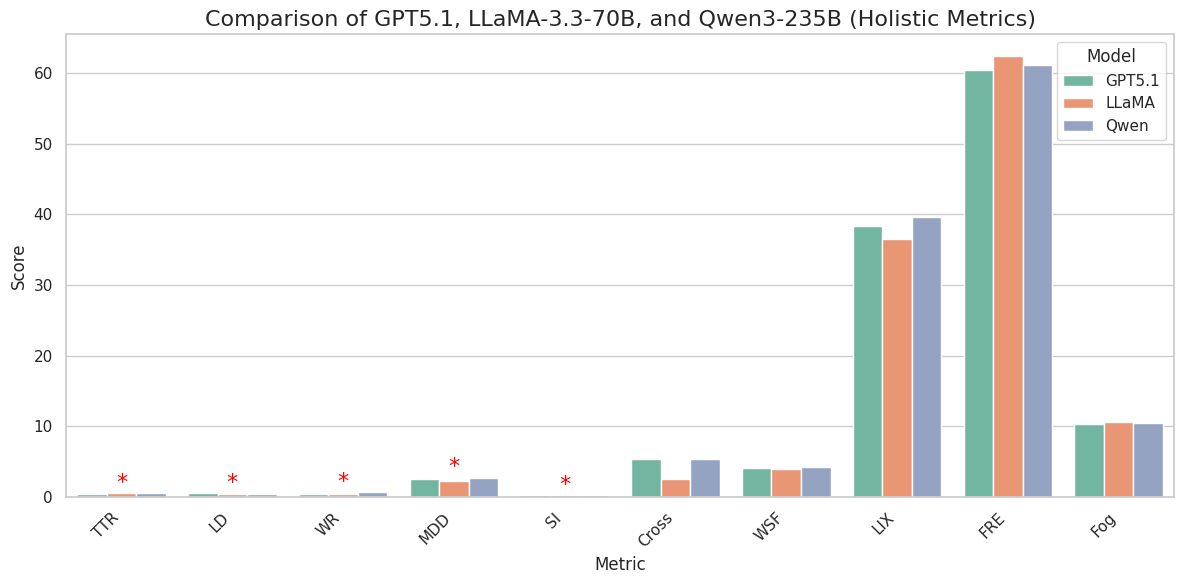

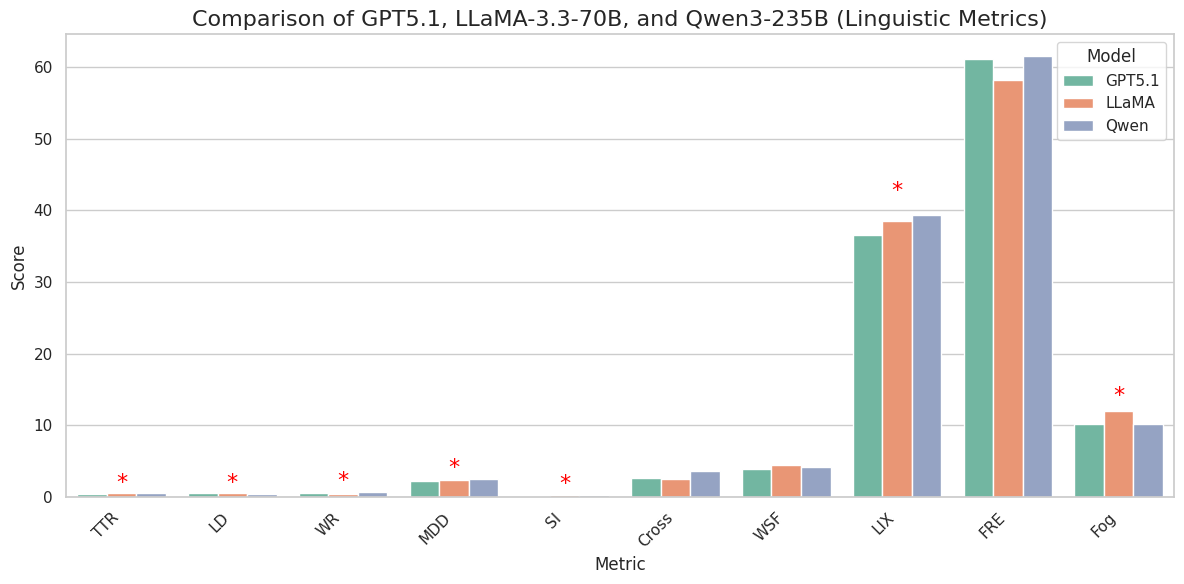

In [113]:

plot_model_comparison(holistic_df, metric_type="Holistic")
plot_model_comparison(linguistic_df, metric_type="Linguistic")

# Ausgangstexte

In [114]:

df0 = pd.read_csv("https://raw.githubusercontent.com/happy522/ChatGPT-as-a-CAT-tool-in-Easy-language-translation_Implemenatation/refs/heads/main/GPT_5_1/Matrix_Scores_GPT5_1_ausgangstexte.csv").sort_values("ID")
df1 = pd.read_csv("https://raw.githubusercontent.com/happy522/ChatGPT-as-a-CAT-tool-in-Easy-language-translation_Implemenatation/refs/heads/main/llama-3.3-70b-instruct/Matrix_Scores_llama-3.3-70b-instruct_Ausgangstexte.csv").sort_values("ID")
df2 = pd.read_csv("https://raw.githubusercontent.com/happy522/ChatGPT-as-a-CAT-tool-in-Easy-language-translation_Implemenatation/refs/heads/main/qwen3-235b-a22b/Matrix_Scores_qwen3-235b-a22b_Ausgangstexte.csv").sort_values("ID")

print("=======================AUSGANGETEXTE=======================\n\n")

print("--------------Holistic------------------\n")
holistic_df, holistic_wins_all, holistic_wins_sig = compare_models(df0, df1, df2, metric_type="Holistic")
print(holistic_df)

print("\n\n--------------Linguistic------------------")
# Linguistic metrics
linguistic_df, ling_wins_all, ling_wins_sig = compare_models(df0, df1, df2, metric_type="Linguistic")
print(linguistic_df)


=======================AUSGANGETEXTE=======================


--------------Holistic------------------


===== Total Wins (All Metrics) =====
GPT5.1 : 2
LLaMA-3.3-70B : 3
Qwen3-235B : 5

===== Significant Wins Only =====
GPT5.1 : 1
LLaMA-3.3-70B : 3
Qwen3-235B : 4


  Metric  n_admin  Friedman_p  Kendalls_W  Significant_(p<0.05)  GPT5.1_mean  \
0    TTR       30    0.000000      0.2664                  True        0.440   
1     LD       30    0.000000      0.3076                  True        0.562   
2     WR       30    0.000000      0.3620                  True        0.471   
3    MDD       30    0.001662      0.3855                  True        2.541   
4     SI       30    0.009590      0.2678                  True        0.235   
5  Cross       30    0.000000      0.3449                  True       13.067   
6    WSF       30    0.026428      0.4758                  True        3.956   
7    LIX       30    0.496585      0.3700                 False       39.266   
8    FRE     

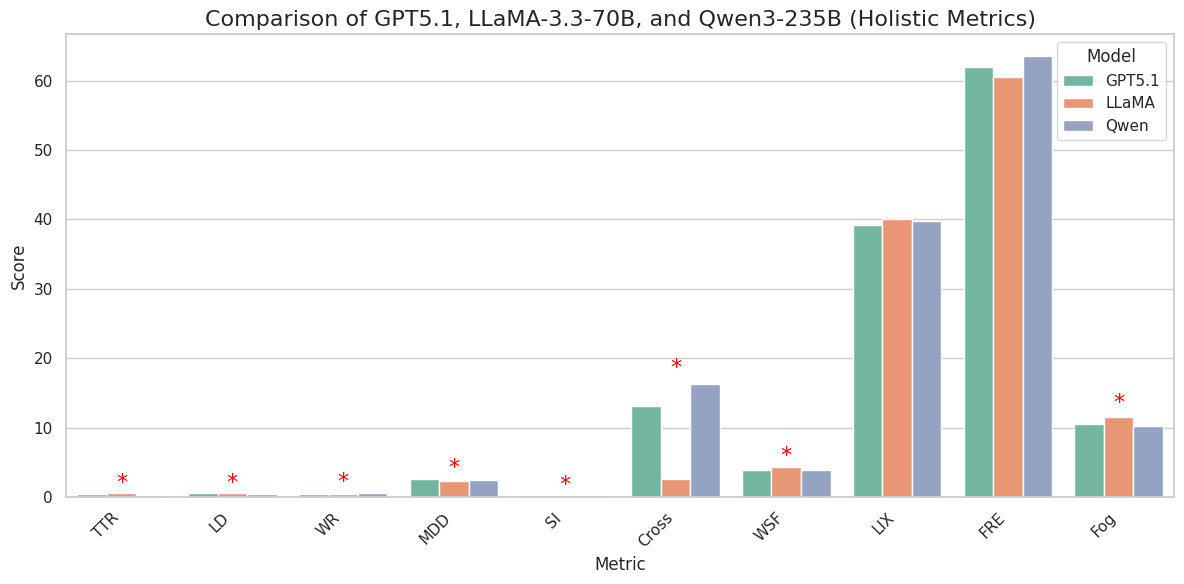

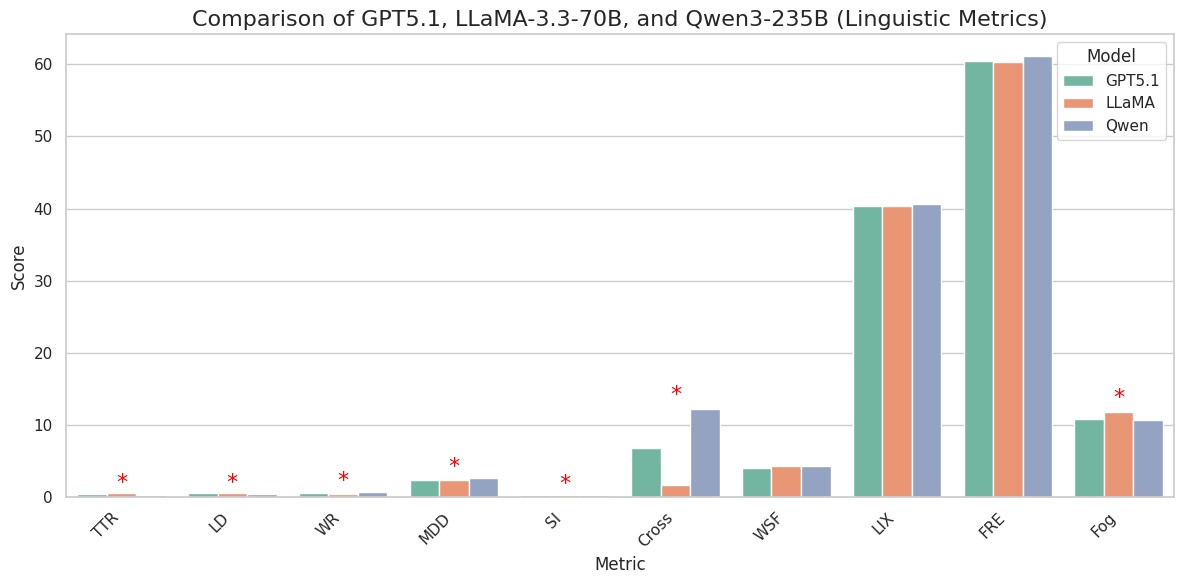

In [115]:
plot_model_comparison(holistic_df, metric_type="Holistic")

plot_model_comparison(linguistic_df, metric_type="Linguistic")